### GTSRB Traffic Sign Image Multi-class classification
#### by Sean Sungil Kim

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# importing necessary modules
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings("ignore")

# custom python scripts
import GTSRB_sungil           # preprocessing
import Models_sungil          # exploratory analysis and model fitting/comparisons

- ### Goal of this project

The goal of this traffic sign image multi-class classification analysis is to explore the effectiveness of different classifiers on lower quality (both in dimension size and color), non-centered traffic sign image (researched and provided by INI Benchmark, which can be downloaded here: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). Image data are heavy both in terms of size and processing time required. It is also difficult to obtain carefully cenetered image data (regardless of what the images are of) in the real world. Having high quality, colored and perfectly centered images can enhance the effectiveness of machine learning and statistical algorithms. However, this requires a significant amount of time, both in the front and the back end. Utilizing lower quality image data is extremely beneficial when computing power is very limited. In addition, being able to use not-so-perfectly cenetered images can save a lot of time. Combining these two factors together, the lower quality and non-centered image data can excel in extremely time sensitive and limited computing power environments, which are not hard to find in the real world.

The original GTSRB data is in fact not low quality. Each image is clear and decently sized (which explains the file size of the training and testing dataset provided on the INI website). It also provides the location of the actual traffic signs within each image in the annotation csv file. Since the goal of this project is to classify low quality traffic signs, each image is resized (downsized) to 16 x 16 pixels and the annotation csv file was not used. Original images are not the same size (sizes vary between 15x15 to 250x250 pixels); however, it did not affect this project since all of them were downsized to 16x16. Because of this size inconsistency, some images with bigger dimensions may have more information than the smaller images post downsizing. The INI Benchmark also provides HOG and haar-like precomputed features. These were not utilized in this project. Everything was started from scratch. Due to my personal limited computing power and time, only the GTSRB training set was used in this project. In the training data alone, there are 39,209 images and total 43 classes.

- ### Exploring with the resized data

In [3]:
# reading the GTSRB data utilizing the custom python script
# grayscaled and downsized to 16x16
# reshaped for classification
num_classes = 43
data_GTSRB, data_class, labels = GTSRB_sungil.load_data(num_classes)
gray_GTSRB = GTSRB_sungil.gray_convrt(data_GTSRB)
resized_data_GTSRB = GTSRB_sungil.resize_all(gray_GTSRB, size = (16, 16))
data_reshaped = GTSRB_sungil.clf_reshape(resized_data_GTSRB)

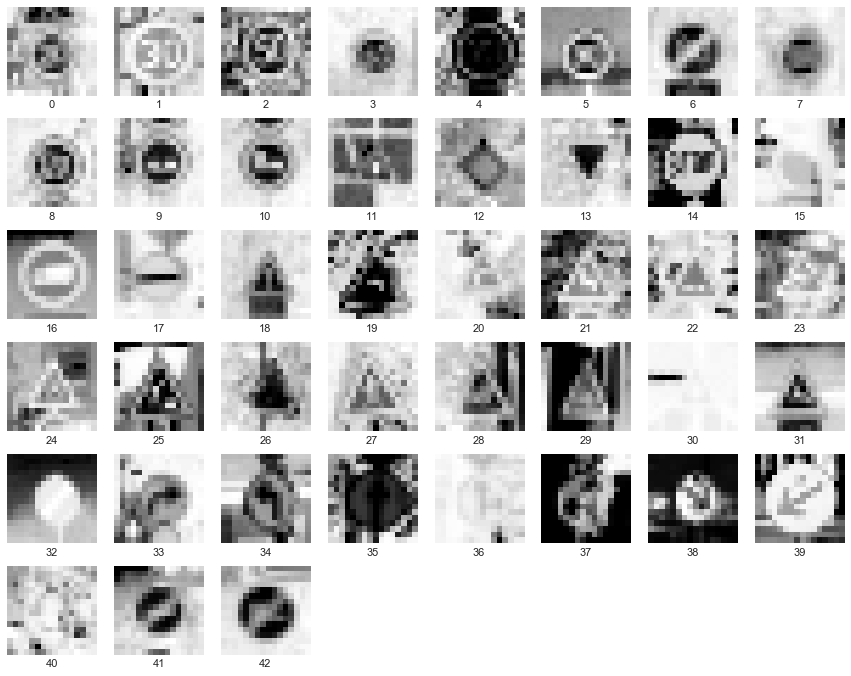

In [4]:
# one image example from each class, post grayscale and downsizing
plt.figure(figsize = (15, 12))
for i in range(num_classes):
    plt.subplot(6, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(resized_data_GTSRB[data_class.tolist().index([i])], cmap = plt.cm.binary)
    plt.xlabel(i)
plt.show()

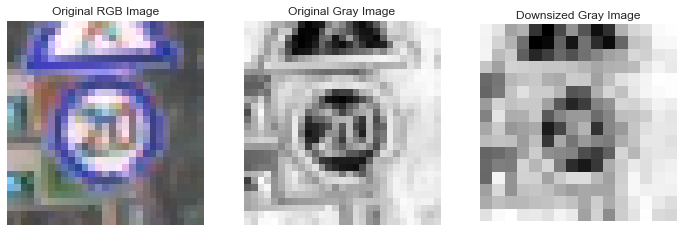

In [5]:
# post grayscale and downsizing comparison 
plt.figure(figsize = (12, 5))
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(resized_data_GTSRB[0], cmap = plt.cm.binary)
plt.title('Downsized Gray Image')
plt.show()

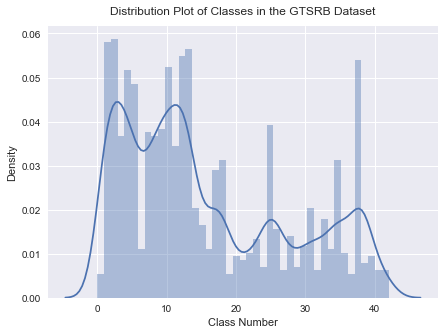

Total 39209 images in the GTSRB dataset
Total 39209 classes in the GTSRB class


In [6]:
# original class distribution
fig = plt.figure(figsize = (7, 5))
sns.distplot(data_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the GTSRB Dataset', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

# length of the data
print('Total %i images in the GTSRB dataset' % len(data_GTSRB))
print('Total %i classes in the GTSRB class' % len(data_class))

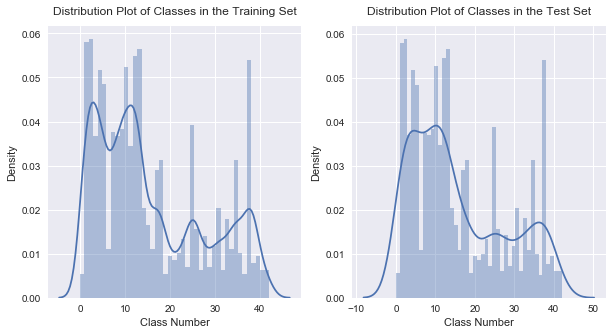

Total of 37052 images in the training data
Total of 2157 images in the test data


In [7]:
# normalizing data, RGB/grayscale images are out of 255
norm_data_reshaped = data_reshaped / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
x_train, x_test, y_train, y_test = train_test_split(norm_data_reshaped, data_class, \
                                                    stratify = data_class, test_size = 0.055)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(y_train, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(y_test, bins = num_classes)
plt.title('Distribution Plot of Classes in the Test Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

print('Total of %i images in the training data' % len(x_train))
print('Total of %i images in the test data' % len(x_test))

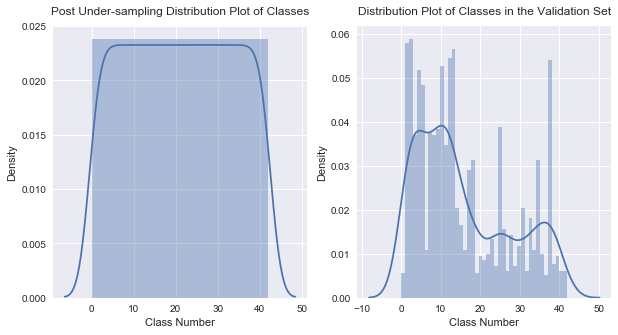

Input data dimensions: (8514, 256)
Target data dimenstions: (8514, 1)
79.79 percent training set, 20.21 percent validation set


In [8]:
# the original data requires extreme computing power and also has class imbalance issues
# due to the limited computing power, undersampling will be performed to reduce computing costs
# and to handle class imbalance issues
# original testing set will be held out as a final validation set
#Models_sungil.compare_clf(norm_x_train, y_train, n_cv = 5)
x_val_OG, y_val_OG = x_test, y_test

# random under-sampling
x_und_smpl_data, y_und_smpl_data = GTSRB_sungil.under_sample(x_train, y_train)

# post under-sampling class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(y_und_smpl_data, bins = num_classes)
plt.title('Post Under-sampling Distribution Plot of Classes', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(y_val_OG, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(x_und_smpl_data) + len(x_val_OG)
print('Input data dimensions:', x_und_smpl_data.shape)
print('Target data dimenstions:', y_und_smpl_data.shape)
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(x_und_smpl_data)/tot_len*100, len(x_val_OG)/tot_len*100))

In [9]:
# model (w/ default parameters) comparison
Models_sungil.compare_clf(x_und_smpl_data, y_und_smpl_data, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.753 (+/- 0.01)
CV Runtime: 11.713051319122314 
-----------------------------------------------------------------
Gradient Boosting Classifier Acc: 0.840 (+/- 0.01)
CV Runtime: 7309.67308306694 
-----------------------------------------------------------------
Ada Boost Classifier Acc: 0.179 (+/- 0.09)
CV Runtime: 147.57923245429993 
-----------------------------------------------------------------
SVM Classifier Acc: 0.330 (+/- 0.02)
CV Runtime: 522.8464555740356 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.885 (+/- 0.01)
CV Runtime: 455.1103262901306 
-----------------------------------------------------------------
XGBoost Classifier Acc: 0.845 (+/- 0.02)
CV Runtime: 3865.54155421257 
-----------------------------------------------------------------
The classifier (with default parameters) wit

- ### Feature Extraction - Thresholding

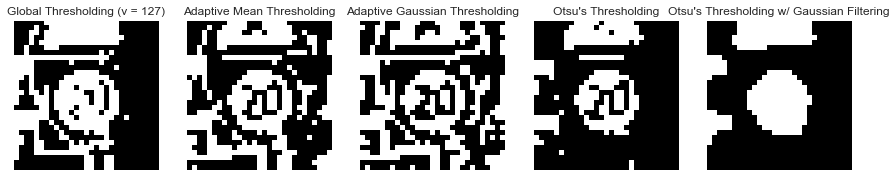

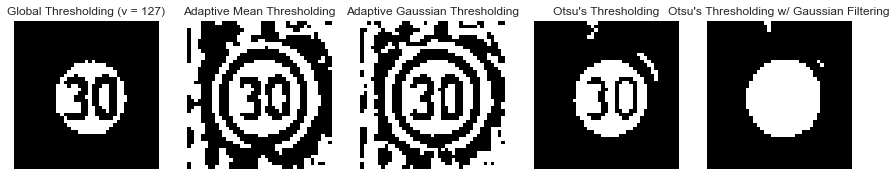

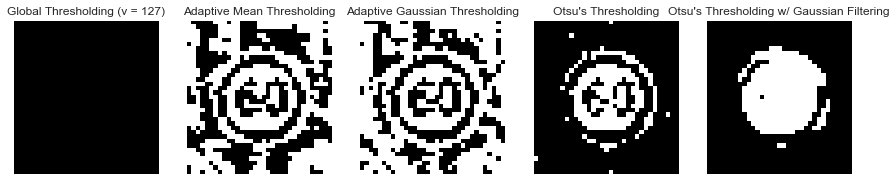

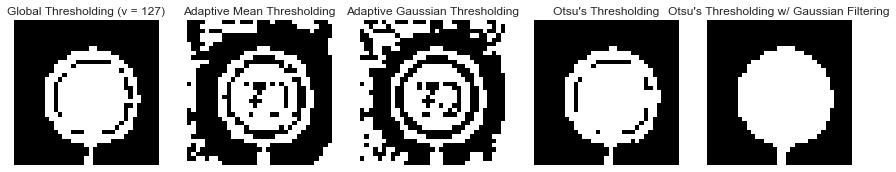

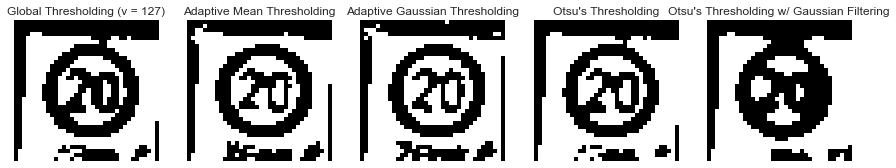

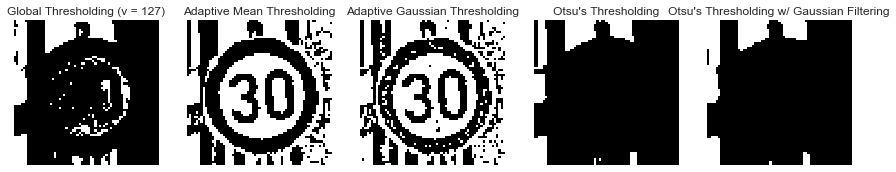

In [10]:
# explore different thresholing methods with different images
img_num_List = [0, 2053, 5254, 7536, 100, 222]
for img_num in img_num_List:
    Models_sungil.compare_thresh(gray_GTSRB[img_num])

Since the Global Thresholding, Otsu's Thresholding, and Otsu's Thresholding w/ Gaussian Filtering caused some of the images to lose the important traffic sign pixel values, only the Adaptive Mean Thresholding and Adaptive Gaussian Thresholding were compared. Adaptive Mean Thresholding illustrated less clutter visually, so it was chosen to be applied on the grayscale data.

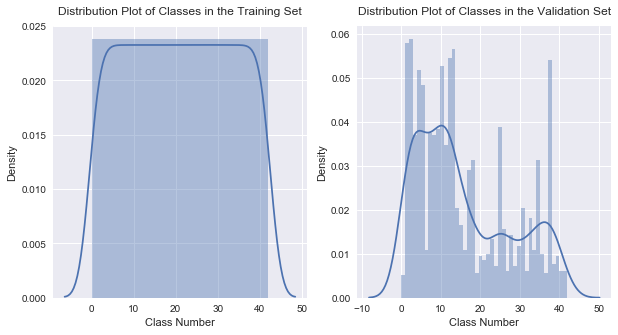

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [11]:
# Adaptive Mean Thresholding
th_gray_data = np.array([cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                                               cv2.THRESH_BINARY, 11, 2) for img in gray_GTSRB])

# resizing
th_resize_data = GTSRB_sungil.resize_all(th_gray_data, size = (16, 16))

# reshaping for classifications
th_reshaped = GTSRB_sungil.clf_reshape(th_resize_data)

# normalizing data, RGB/grayscale images are out of 255
norm_th_reshaped = th_reshaped / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
th_train, th_x_val, th_class, th_y_val = train_test_split(norm_th_reshaped, data_class,\
                                                          stratify = data_class, test_size = 0.055)

# random under-sampling
und_th_train, und_th_class = GTSRB_sungil.under_sample(th_train, th_class)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_th_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(th_y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_th_train) + len(th_x_val)
print('Total of %i images in the training data' % len(und_th_train))
print('Total of %i images in the validation data' % len(th_x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_th_train)/tot_len*100, len(th_x_val)/tot_len*100))

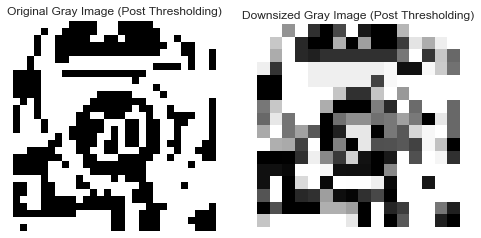

In [12]:
# post thresholding and downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(th_gray_data[0], cmap = plt.cm.binary)
plt.title('Original Gray Image (Post Thresholding)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(th_resize_data[0], cmap = plt.cm.binary)
plt.title('Downsized Gray Image (Post Thresholding)')
plt.show()

In [13]:
# model (w/ default parameters) comparison
Models_sungil.compare_clf(und_th_train, und_th_class, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.693 (+/- 0.02)
CV Runtime: 16.246086359024048 
-----------------------------------------------------------------
Gradient Boosting Classifier Acc: 0.871 (+/- 0.02)
CV Runtime: 7262.861037969589 
-----------------------------------------------------------------
Ada Boost Classifier Acc: 0.326 (+/- 0.12)
CV Runtime: 76.97814774513245 
-----------------------------------------------------------------
SVM Classifier Acc: 0.794 (+/- 0.03)
CV Runtime: 442.92710638046265 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.801 (+/- 0.02)
CV Runtime: 515.3083746433258 
-----------------------------------------------------------------
XGBoost Classifier Acc: 0.858 (+/- 0.02)
CV Runtime: 3526.795161485672 
-----------------------------------------------------------------
The classifier (with default parameters) w

- ### Feature Extraction - Canny Edge Detection

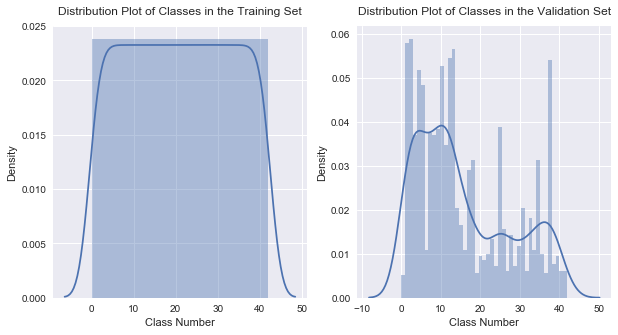

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [14]:
# edge detection and resizing
data_edge = GTSRB_sungil.canny_edge_convrt(gray_GTSRB)
edge_resize_data = GTSRB_sungil.resize_all(data_edge, size = (16, 16))

# reshaping for classifications
edge_reshaped = GTSRB_sungil.clf_reshape(edge_resize_data)

# normalizing data, RGB/grayscale images are out of 255
norm_edge_reshaped = edge_reshaped / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
edge_train, edge_x_val, edge_class, edge_y_val = train_test_split(norm_edge_reshaped, data_class,\
                                                                  stratify = data_class, \
                                                                  test_size = 0.055)

# random under-sampling
und_edge_train, und_edge_class = GTSRB_sungil.under_sample(edge_train, edge_class)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_edge_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(edge_y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_edge_train) + len(edge_x_val)
print('Total of %i images in the training data' % len(und_edge_train))
print('Total of %i images in the validation data' % len(edge_x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_edge_train)/tot_len*100, len(edge_x_val)/tot_len*100))

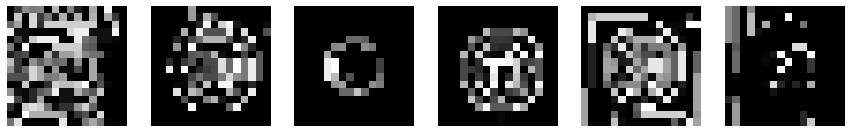

In [15]:
# first 10 edge detected images
img_num_List = [0, 2053, 5254, 7536, 100, 222]
fig = plt.figure(figsize = (15, 6))
for i in range(len(img_num_List)):
    plt.subplot(1, 6, i+1)
    plt.imshow(edge_resize_data[img_num_List[i]], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

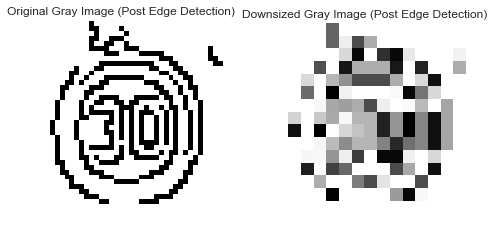

In [16]:
# post edge detection and downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_edge[2053], cmap = plt.cm.binary)
plt.title('Original Gray Image (Post Edge Detection)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(edge_resize_data[2053], cmap = plt.cm.binary)
plt.title('Downsized Gray Image (Post Edge Detection)')
plt.show()

In [17]:
# model (w/ default parameters) comparison
Models_sungil.compare_clf(und_edge_train, und_edge_class, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.362 (+/- 0.02)
CV Runtime: 6.74671196937561 
-----------------------------------------------------------------
Gradient Boosting Classifier Acc: 0.495 (+/- 0.01)
CV Runtime: 5958.646957397461 
-----------------------------------------------------------------
Ada Boost Classifier Acc: 0.127 (+/- 0.03)
CV Runtime: 57.12793827056885 
-----------------------------------------------------------------
SVM Classifier Acc: 0.372 (+/- 0.02)
CV Runtime: 436.39146542549133 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.425 (+/- 0.01)
CV Runtime: 329.0484800338745 
-----------------------------------------------------------------
XGBoost Classifier Acc: 0.544 (+/- 0.03)
CV Runtime: 3275.315999984741 
-----------------------------------------------------------------
The classifier (with default parameters) wit

- ### Unsupervised Learning - Principal Component Analysis

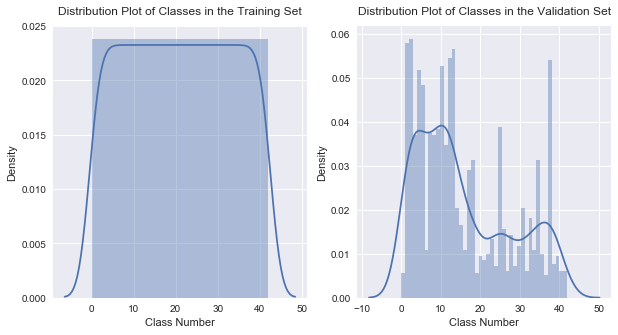

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [18]:
# normalizing data, RGB/grayscale images are out of 255
norm_gray_reshaped = data_reshaped / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
gray_train, gray_x_val, gray_class, gray_y_val = train_test_split(norm_gray_reshaped, data_class,\
                                                                  stratify = data_class, \
                                                                  test_size = 0.055)

# random under-sampling
und_gray_train, und_gray_class = GTSRB_sungil.under_sample(gray_train, gray_class)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_gray_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(gray_y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_gray_train) + len(gray_x_val)
print('Total of %i images in the training data' % len(und_gray_train))
print('Total of %i images in the validation data' % len(gray_x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_gray_train)/tot_len*100, len(gray_x_val)/tot_len*100))

In [19]:
# performing PCA on the reshaped grascale data
PCA_Final = Models_sungil.compare_PCA(und_gray_train, 95, ['auto', 'full', 'arpack', 'randomized'])
prin_comps = PCA_Final.transform(und_gray_train)
print('\nShape of the original normalized grayscale data:', und_gray_train.shape)
print('Shape of the newly computed principal components:', prin_comps.shape)

Solver: auto will be used.
In order to capture at least 95 % of variance within the original data, 72 principal components are needed.

Cumulative % Variance Captured:
 [0.50801126 0.6525222  0.69726492 0.73195126 0.75728661 0.77429116
 0.78736411 0.79764448 0.80775687 0.81672134 0.82463118 0.83121203
 0.83753581 0.84311257 0.84824477 0.85302592 0.85741116 0.86144963
 0.86515702 0.8685259  0.87177512 0.87494432 0.87793641 0.88089271
 0.88376826 0.88654446 0.88924044 0.89169795 0.89405535 0.89638497
 0.89858963 0.90072064 0.90273632 0.90470836 0.90658094 0.90844915
 0.91021231 0.91195981 0.91365323 0.91526358 0.91679509 0.91831409
 0.9198113  0.92124857 0.9226276  0.92400621 0.92535519 0.92666608
 0.92793575 0.92918254 0.93039592 0.93159522 0.93277238 0.93388599
 0.93499084 0.93605802 0.93711834 0.93814392 0.93913805 0.94010691
 0.94106643 0.94198818 0.94288378 0.94375836 0.94462108 0.94545557
 0.94625682 0.9470466  0.94782167 0.94857686 0.94931272 0.95003972]

Shape of the original nor

In [20]:
# model (w/ default parameters) comparison
Models_sungil.compare_clf(prin_comps, und_gray_class, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.535 (+/- 0.03)
CV Runtime: 8.21187686920166 
-----------------------------------------------------------------
Gradient Boosting Classifier Acc: 0.690 (+/- 0.03)
CV Runtime: 3538.1096608638763 
-----------------------------------------------------------------
Ada Boost Classifier Acc: 0.209 (+/- 0.02)
CV Runtime: 99.93282389640808 
-----------------------------------------------------------------
SVM Classifier Acc: 0.489 (+/- 0.03)
CV Runtime: 157.5582082271576 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.872 (+/- 0.02)
CV Runtime: 171.037828207016 
-----------------------------------------------------------------
XGBoost Classifier Acc: 0.727 (+/- 0.02)
CV Runtime: 2382.9009857177734 
-----------------------------------------------------------------
The classifier (with default parameters) wit

- ### Wrapper-based Feature Selection (w/ RandomForestClassifier)

Wrapper Select:

Selected: [[71], [72], [85], [86], [87], [88], [89], [90], [91], [100], [101], [102], [103], [104], [105], [106], [107], [108], [116], [117], [118], [119], [120], [121], [122], [123], [124], [132], [133], [134], [135], [136], [137], [138], [139], [140], [148], [149], [150], [151], [152], [153], [154], [155], [165], [166], [167], [168], [169], [170], [171], [181], [182], [183], [184], [185], [186], [187], [197], [199], [200], [202], [203], [216]]
Features (total/selected): 256 / 64


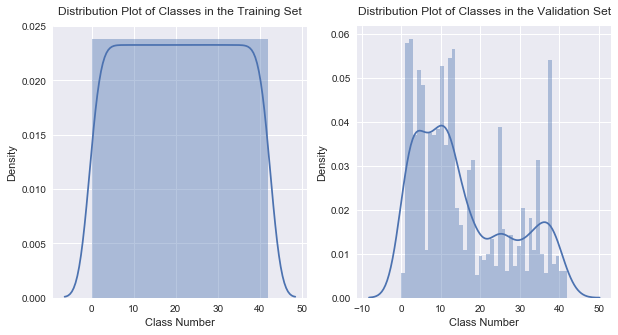

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [21]:
# wrapper-based feature selection
fs_data = Models_sungil.wrapper_based_fs(data_reshaped, data_class, clf = RandomForestClassifier())

# normalizing data, RGB/grayscale images are out of 255
norm_fs_data = fs_data / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
fs_train, fs_x_val, fs_class, fs_y_val = train_test_split(norm_fs_data, data_class,\
                                                          stratify = data_class, test_size = 0.055)

# random under-sampling
und_fs_train, und_fs_class = GTSRB_sungil.under_sample(fs_train, fs_class)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_fs_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(fs_y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_fs_train) + len(fs_x_val)
print('Total of %i images in the training data' % len(und_fs_train))
print('Total of %i images in the validation data' % len(fs_x_val))
print('%0.2f percent training set, %0.2f percent validation set' % \
      (len(und_fs_train)/tot_len*100, len(fs_x_val)/tot_len*100))

In [22]:
# model (w/ default parameters) comparison
Models_sungil.compare_clf(und_fs_train, und_fs_class, cv = 5)

Comparing Different Classifiers:
-----------------------------------------------------------------
Random Forest Classifier Acc: 0.802 (+/- 0.01)
CV Runtime: 5.6491405963897705 
-----------------------------------------------------------------
Gradient Boosting Classifier Acc: 0.830 (+/- 0.01)
CV Runtime: 2010.6890652179718 
-----------------------------------------------------------------
Ada Boost Classifier Acc: 0.174 (+/- 0.03)
CV Runtime: 53.2347526550293 
-----------------------------------------------------------------
SVM Classifier Acc: 0.479 (+/- 0.03)
CV Runtime: 161.04362154006958 
-----------------------------------------------------------------
Multi-layer Perceptron Classifier Acc: 0.899 (+/- 0.01)
CV Runtime: 235.15239930152893 
-----------------------------------------------------------------
XGBoost Classifier Acc: 0.832 (+/- 0.01)
CV Runtime: 1018.0708589553833 
-----------------------------------------------------------------
The classifier (with default parameters)

Random Forest was extremely fast, with decent cv-accuracy. Multi-layer Perceptron Classifier had the highest accuracy among all classifiers explored in this project (on lower quality, non-centered data)

- ### Hypertuning parameters - Top 3 models

#### Random Forest Classifier w/ Feature Selected (Wrapper-based) Data

In [23]:
# preparing a parameter grid
param_grid = {"n_estimators": sp_randint(10, 1000), "max_depth": [3, 4, None], "max_features": ['auto', 'log2', None], \
              "min_samples_split": sp_randint(2, 16), "criterion": ["gini", "entropy"]}

# creating and fitting a Random Forest Classifier, testing random param_grids
start_ts = time.time()
model = RandomForestClassifier()
rsearch = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'accuracy', cv = 5)
rsearch.fit(und_fs_train, und_fs_class)
print("CV Runtime:", time.time() - start_ts)

# summarizing the results of the random parameter search
print('The best RandomizedSearchCV score:', rsearch.best_score_)
print('The best estimator:\n', rsearch.best_estimator_)

CV Runtime: 12122.635693788528
The best RandomizedSearchCV score: 0.9068592905802209
The best estimator:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=985, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [24]:
# cv = 5 training accuracy
scorers = {'Accuracy': 'accuracy'}
start_ts = time.time()
scores = cross_validate(rsearch.best_estimator_, und_fs_train, und_fs_class, scoring = scorers, cv = 5)
scores_Acc = scores['test_Accuracy']
print("Random Forest Classifier (w/ hypertuned parameters) Acc: %0.3f (+/- %0.2f)" % \
      (scores_Acc.mean(), scores_Acc.std() * 2))   
print("CV Runtime:", time.time() - start_ts)

trainacc_List = []
trainacc_List.append(scores_Acc.mean())

Random Forest Classifier (w/ hypertuned parameters) Acc: 0.906 (+/- 0.00)
CV Runtime: 498.98788714408875


Random Forest Classifier (w/ hypertuned parameters) Testing Acc: 0.879
CV Runtime: 117.18548226356506
Random Forest classification report: 

               precision    recall  f1-score   support

           0       0.41      1.00      0.59        12
           1       0.84      0.75      0.79       122
           2       0.77      0.66      0.71       124
           3       0.77      0.81      0.79        78
           4       0.83      0.72      0.77       109
           5       0.74      0.66      0.69       102
           6       0.96      1.00      0.98        23
           7       0.82      0.81      0.82        79
           8       0.77      0.77      0.77        78
           9       0.99      0.95      0.97        81
          10       0.96      0.95      0.96       111
          11       1.00      0.90      0.95        73
          12       0.94      0.91      0.93       115
          13       0.97      0.97      0.97       119
          14       1.00      1.00      1.00    

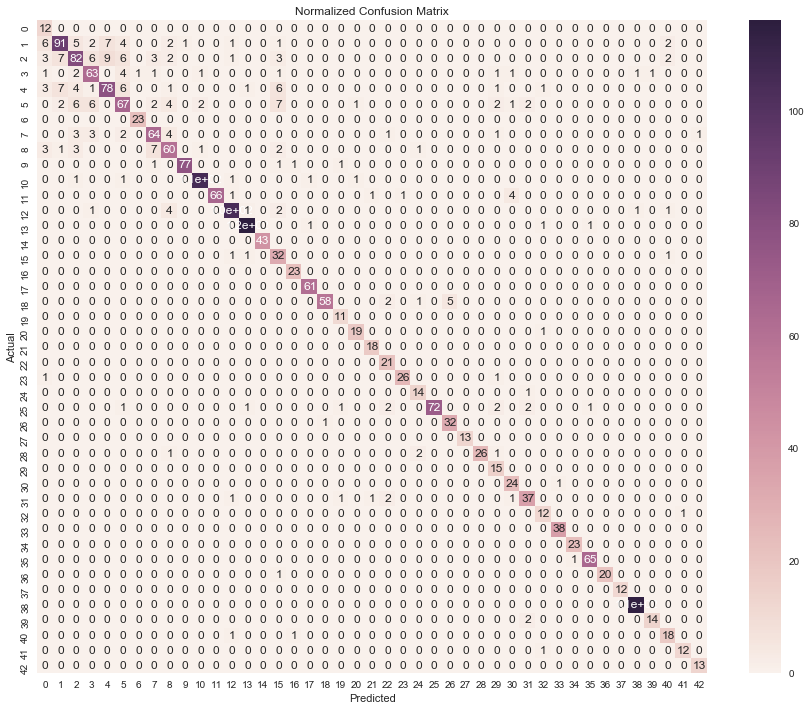

In [25]:
# testing on the unbalanced validation set
start_ts = time.time()
rsearch.best_estimator_.fit(und_fs_train, und_fs_class)
test_acc = rsearch.best_estimator_.score(fs_x_val, fs_y_val)
print('Random Forest Classifier (w/ hypertuned parameters) Testing Acc: %0.3f'% (test_acc))
print("CV Runtime:", time.time() - start_ts)

# classification report
pred = rsearch.best_estimator_.predict(fs_x_val)
print("Random Forest classification report:", "\n\n", classification_report(fs_y_val, pred))
precision, recall, fbeta_score, support = precision_recall_fscore_support(fs_y_val, pred, average = 'weighted')

clf_List = []
testacc_List = []
precision_List = []
recall_List = []
fscore_List = []
clf_List.append('Feature Selected (Wrapper-based) Random Forest Classifier')
testacc_List.append(test_acc)
precision_List.append(precision)
recall_List.append(recall)
fscore_List.append(fbeta_score)

# accuracy confusion matrix
cm = confusion_matrix(fs_y_val, pred)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

#### Multi-layer Percentron Classifier w/ Feature Selected (Wrapper-based) Data

In [26]:
# adam solver will not be explored for faster runtimes
param_grid = {'hidden_layer_sizes': sp_randint(10, 500), 'activation': ['logistic', 'tanh', 'relu'],\
              'solver': ['lbfgs', 'sgd'], 'learning_rate' : ['constant', 'adaptive'], 'max_iter': sp_randint(20, 2000)}

# creating and fitting a Multi-layer Perceptron Classifier, testing random param_grids
start_ts = time.time()
model = MLPClassifier()
rsearch = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'accuracy', cv = 5)
rsearch.fit(und_fs_train, und_fs_class)
print("CV Runtime:", time.time() - start_ts)

# summarizing the results of the random parameter search
print('The best RandomizedSearchCV score:', rsearch.best_score_)
print('The best estimator:\n', rsearch.best_estimator_)

CV Runtime: 25216.135255098343
The best RandomizedSearchCV score: 0.9248296922715528
The best estimator:
 MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=499, learning_rate='constant',
       learning_rate_init=0.001, max_iter=600, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [27]:
# cv = 5 training accuracy
scorers = {'Accuracy': 'accuracy'}
start_ts = time.time()
scores = cross_validate(rsearch.best_estimator_, und_fs_train, und_fs_class, scoring = scorers, cv = 5)
scores_Acc = scores['test_Accuracy']
print("Multi-layer Perceptron Classifier Acc: %0.3f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))   
print("CV Runtime:", time.time()-start_ts)

trainacc_List.append(scores_Acc.mean())

Multi-layer Perceptron Classifier Acc: 0.924 (+/- 0.01)
CV Runtime: 626.340963602066


Multi-layer Perceptron Classifier (w/ hypertuned parameters) Testing Acc: 0.911
CV Runtime: 177.0259518623352
kNN classification report: 

               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.90      0.82      0.86       122
           2       0.85      0.81      0.83       124
           3       0.87      0.86      0.86        78
           4       0.89      0.88      0.88       109
           5       0.86      0.83      0.85       102
           6       0.96      1.00      0.98        23
           7       0.93      0.90      0.92        79
           8       0.88      0.94      0.91        78
           9       0.91      0.96      0.93        81
          10       0.95      0.96      0.96       111
          11       0.94      0.92      0.93        73
          12       0.98      0.84      0.91       115
          13       0.98      0.92      0.95       119
          14       0.98      0.98      0.98      

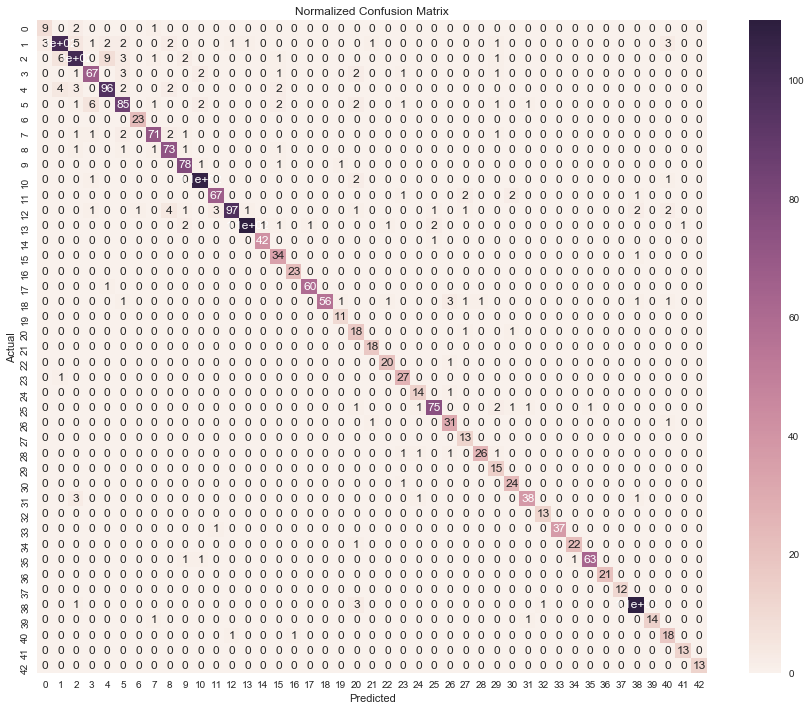

In [28]:
# testing on the unbalanced validation set
start_ts = time.time()
rsearch.best_estimator_.fit(und_fs_train, und_fs_class)
test_acc = rsearch.best_estimator_.score(fs_x_val, fs_y_val)
print('Multi-layer Perceptron Classifier (w/ hypertuned parameters) Testing Acc: %0.3f'% (test_acc))
print("CV Runtime:", time.time() - start_ts)

# classification report
pred = rsearch.best_estimator_.predict(fs_x_val)
print("kNN classification report:", "\n\n", classification_report(fs_y_val, pred))
precision, recall, fbeta_score, support = precision_recall_fscore_support(fs_y_val, pred, average = 'weighted')

clf_List.append('Feature Selected (Wrapper-based) Multi-layer Perceptron Classifier')
testacc_List.append(test_acc)
precision_List.append(precision)
recall_List.append(recall)
fscore_List.append(fbeta_score)

# accuracy confusion matrix
cm = confusion_matrix(fs_y_val, pred)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

#### Multi-layer Percentron Classifier w/ Principal Components

In [29]:
# adam solver will not be explored for faster runtimes
param_grid = {'hidden_layer_sizes': sp_randint(10, 500), 'activation': ['logistic', 'tanh', 'relu'],\
              'solver': ['lbfgs', 'sgd'], 'learning_rate' : ['constant', 'adaptive'], 'max_iter': sp_randint(20, 2000)}

# creating and fitting a Multi-layer Perceptron Classifier, testing random param_grids
start_ts = time.time()
model = MLPClassifier()
rsearch = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'accuracy', cv = 5)
rsearch.fit(prin_comps, und_gray_class)
print("CV Runtime:", time.time() - start_ts)

# summarizing the results of the random parameter search
print('The best RandomizedSearchCV score:', rsearch.best_score_)
print('The best estimator:\n', rsearch.best_estimator_)

CV Runtime: 12382.06505227089
The best RandomizedSearchCV score: 0.8726802912849424
The best estimator:
 MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=394, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1690, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [30]:
# cv = 5 training accuracy
scorers = {'Accuracy': 'accuracy'}
start_ts = time.time()
scores = cross_validate(rsearch.best_estimator_, prin_comps, und_gray_class, scoring = scorers, cv = 5)
scores_Acc = scores['test_Accuracy']
print("Multi-layer Perceptron Classifier Acc: %0.3f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))   
print("CV Runtime:", time.time()-start_ts)

trainacc_List.append(scores_Acc.mean())

Multi-layer Perceptron Classifier Acc: 0.867 (+/- 0.01)
CV Runtime: 668.0203845500946


Multi-layer Perceptron Classifier (w/ hypertuned parameters) Testing Acc: 0.824
CV Runtime: 182.3799548149109
kNN classification report: 

               precision    recall  f1-score   support

           0       0.41      1.00      0.59        12
           1       0.82      0.66      0.73       122
           2       0.73      0.66      0.69       124
           3       0.66      0.67      0.66        78
           4       0.83      0.81      0.82       109
           5       0.66      0.75      0.71       102
           6       0.92      1.00      0.96        23
           7       0.69      0.80      0.74        79
           8       0.75      0.72      0.73        78
           9       0.97      0.85      0.91        81
          10       0.94      0.92      0.93       111
          11       0.97      0.79      0.87        73
          12       0.86      0.70      0.78       115
          13       0.90      0.87      0.89       119
          14       0.89      0.79      0.84      

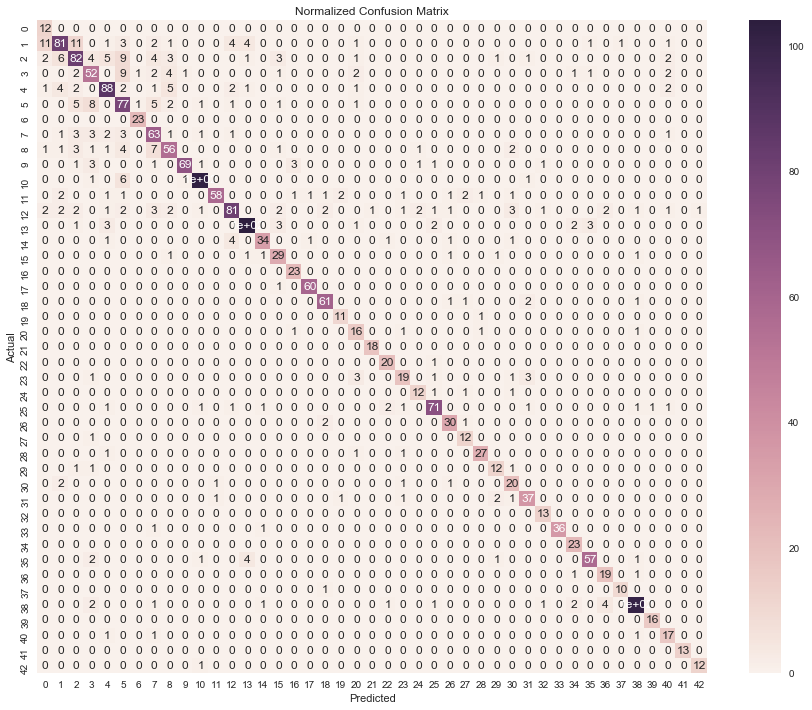

In [33]:
# testing on the unbalanced validation set
start_ts = time.time()
rsearch.best_estimator_.fit(prin_comps, und_gray_class)
prin_comps_val = PCA_Final.transform(gray_x_val)
test_acc = rsearch.best_estimator_.score(prin_comps_val, gray_y_val)
print('Multi-layer Perceptron Classifier (w/ hypertuned parameters) Testing Acc: %0.3f'% (test_acc))
print("CV Runtime:", time.time() - start_ts)

# classification report
pred = rsearch.best_estimator_.predict(prin_comps_val)
print("kNN classification report:", "\n\n", classification_report(gray_y_val, pred))
precision, recall, fbeta_score, support = precision_recall_fscore_support(gray_y_val, pred, average = 'weighted')

clf_List.append('Multi-layer Perceptron Classifier w/ Principal Components')
testacc_List.append(test_acc)
precision_List.append(precision)
recall_List.append(recall)
fscore_List.append(fbeta_score)

# accuracy confusion matrix
cm = confusion_matrix(gray_y_val, pred)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

In [34]:
# final results table
final_results = pd.DataFrame({'Classifiers': clf_List, 'Training (cv = 5) Accuracy': trainacc_List,\
                              'Testing Accuracy': testacc_List, 'Precision Score': precision_List,\
                              'Recall Score': recall_List, 'F-Score': fscore_List}).set_index('Classifiers')
final_results

,Training (cv = 5) Accuracy,Testing Accuracy,Precision Score,Recall Score,F-Score
Classifiers,,,,,
Feature Selected (Wrapper-based) Random Forest Classifier,0.905826,0.878999,0.887589,0.878999,0.879842
Feature Selected (Wrapper-based) Multi-layer Perceptron Classifier,0.924114,0.910524,0.916128,0.910524,0.911308
Multi-layer Perceptron Classifier w/ Principal Components,0.866544,0.823829,0.833671,0.823829,0.825159


The learning processes were executed on under-sampled data. In order to test the finalized (top 3) models on the data with original data integrity, the validation set was remained unbalanced. Therefore, the weighted precision, recall and f-score were used as performance evaluation metrics in the testing phase. Testing accuracy is not a good metric to use, when there are extreme class imbalance issues. High precision and recall scores illustrate that the classifier is returning accurate results (precision), as well as a majority of all positive results (recall). An ideal algorithm with high precision and recall will return many predictions classified correctly.

Surprisingly, the Multi-layer Perceptron classifier fit on the principal components performed worse compared to the Random Forest classifier fit on the feature selected data, as shown in the final results table above. The weighted precision, recall, and f-score were all about 0.05 lower than the ones from the feature selected Random Forest classifier. The classifier with the best performance was the feature selected Multi-layer Perceptron classifier, with had the precision of 0.92, recall of 0.91 and f-score of 0.91. The feature selected Multi-layer Perceptron classifier was able to correctly classify some of the highly populated labels better than the feature selected Random Forest classifier, whcih resulted in higher performance scores. However, considering the significantly lower time and computing costs taken for the feature selected Random Forest model, both are considered important.

- ### Future Work

Further developing this multi-class classification problem will ultimately result in discovering better performing models. One way of doing this is by combining some of the feature extraction and dimension reduction/feature selection methods. The feature extraction process in this project was heavily affected by the downsizing that came afterwords. Implementing dimension reduction and/or feature selection algorithms without this downsizing (for the purpose of time and computing cost reduction) will be interesting to explore. In addition, exploring with different randomizedsearchCV will be beneficial. The Multi-layer Perceptron model was proven to perform well on image data. Increasing the hidden layer sizes will make the model perform better; however, it was not explored in this project due to the extremely limited time and computing power. 

If under-sampling is not the route of interest, another method of developing this project is by providing some bias to minority classes by using compute_class_weight and class_weight parameter while training the model on the unbalanced data. This will provide some bias towards the minority classes while training the model, which will ultimately help improving performance of the model.